## Preparing the data

We split the dataset into training, validation and test datasets.

The input should be a csv file, as it can be downloaded from WRDS

## Import libraries and datasets

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt

In [7]:
df = pd.read_csv("Dataset.csv")
tickers = df.groupby('Ticker')
dates = df.date.unique()
dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

In [8]:
print(df)

      PERMNO        date      BIDLO      ASKHI        PRC        VOL  \
0      10107    1/2/2019   98.94000  101.75000  101.12000   35347045   
1      10107    1/3/2019   97.20000  100.18500   97.40000   42570779   
2      10107    1/4/2019   98.93000  102.51000  101.93000   44032862   
3      10107    1/7/2019  100.98000  103.26810  102.06000   35650303   
4      10107    1/8/2019  101.71340  103.97000  102.80000   31531077   
...      ...         ...        ...        ...        ...        ...   
3769   84398  12/22/2023  471.70001  475.38000  473.64999   67160419   
3770   84398  12/26/2023  473.98999  476.57999  475.64999   55386952   
3771   84398  12/27/2023  474.89001  476.66000  476.51001   68000311   
3772   84398  12/28/2023  476.26001  477.54999  476.69000   77158116   
3773   84398  12/29/2023  473.29999  477.03000  475.31000  122283149   

            BID        ASK    NUMTRD Ticker  
0     101.12000  101.13000  239618.0    SPY  
1      97.35000   97.38000  302446.0    SPY

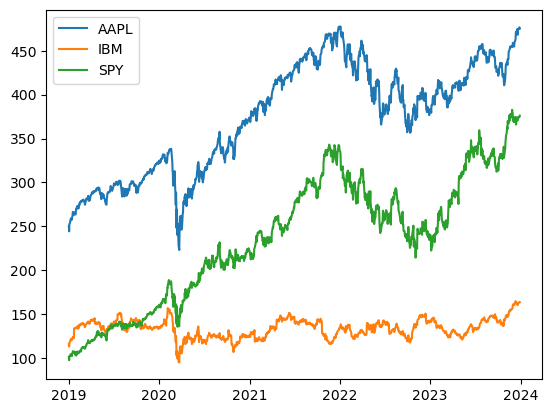

In [9]:
for name, data in tickers:
    plt.plot(dates, data.PRC.values, '-', label = name)
plt.legend()

## Creating training, validation and testing dataset

- For each ticker, we create a dataset of the form $\{(x_t,y_t)\}_{t=n,...,N}$, where $x_t$ is the vector containing all prices between time $t-n$ and time $t$, and $y_t$ is the vector containing prices at time $t+1$.

- We will experiment with predicting a time series based on its previous prices for the last $n$ days

- If we want to include more predicting variables, such as daily high and low and volumes, they can just be added in the definition of `ts`

In [10]:
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps].flatten() for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps][:, -1]
                  for idx in range(n_obs)])
    return X, y

In [11]:
ts = {}
X = {}
y = {}
X_train_full = {}
y_train_full = {}
X_test = {}
y_test = {}
X_train = {}
y_train = {}
X_valid = {}
y_valid = {}
split_ind = {}
split_ind_2 = {}
for name, data in tickers:
    data = data[['PRC']].diff().dropna()
    ts[name] = data.values#.flatten()
    X[name], y[name] = ts_split(ts[name])
    split_ind[name] = int(X[name].shape[0]*0.8)
    X_train_full[name], y_train_full[name] = X[name][:split_ind[name]], y[name][:split_ind[name]]
    X_test[name], y_test[name] = X[name][split_ind[name]:], y[name][split_ind[name]:]
    split_ind_2[name] = int(X_train_full[name].shape[0]*0.8)
    X_train[name], y_train[name] = X_train_full[name][:split_ind_2[name]], y_train_full[name][:split_ind_2[name]]
    X_valid[name], y_valid[name] = X_train_full[name][split_ind_2[name]:], y_train_full[name][split_ind_2[name]:]

Check results:

In [12]:
print(X_train_full['SPY'][0])
print(X_train_full['SPY'][1])
print(y_train_full['SPY'][0])

[-3.72  4.53  0.13  0.74  1.47 -0.67 -0.8  -0.75  2.96  0.37]
[ 4.53  0.13  0.74  1.47 -0.67 -0.8  -0.75  2.96  0.37  0.74]
[0.74]


Save datasets

In [13]:
np.save('X_train.npy',X_train)
np.save('y_train.npy',y_train)
np.save('X_valid.npy',X_valid)
np.save('y_valid.npy',y_valid)
np.save('X_test.npy',X_test)
np.save('y_test.npy',y_test)


Example on how to load a dataset

In [14]:
X_train_load_ex=np.load('X_train.npy', allow_pickle=True)

## Example for linear regression

In [15]:
from sklearn.linear_model import LinearRegression

y_pred = {}
model = LinearRegression()
model.fit(X_train['SPY'], y_train['SPY'].ravel())
y_pred['SPY'] = model.predict(X_test['SPY'])

In [16]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test['SPY'], y_pred['SPY']))

4.790779008966088

Alternatively, we can simply train a seingle neuron of neural network, without activation function

In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [18]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [19]:
reset_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[10]),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam")

In [20]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  min_delta=0.01,
                                                  restore_best_weights=True)
run = model.fit(X_train['SPY'], y_train['SPY'], epochs=400,
                validation_data=(X_valid['SPY'], y_valid['SPY']),
                callbacks=[early_stopping_cb], verbose=0)
pd.DataFrame(run.history).iloc[-11:]

,loss,val_loss
75,13.831727,33.978111
76,13.828960,33.975555
77,13.826459,33.973614
78,13.824188,33.972214
79,13.822135,33.971298
80,13.820270,33.970810
81,13.818584,33.970692
82,13.817055,33.970909
83,13.815670,33.971420
84,13.814410,33.972183


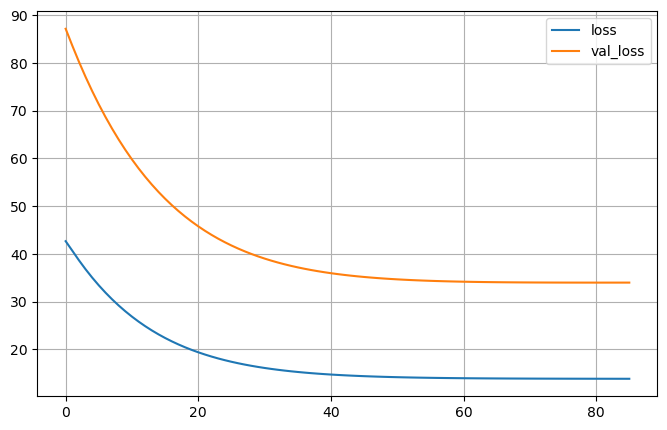

In [21]:
pd.DataFrame(run.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

The RMSE should be similar to the one obtained performing linear regression

In [22]:
ypred = model.predict(X_test['SPY'])
np.sqrt(mean_squared_error(y_test['SPY'], ypred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


4.7852644762981